# ADN_T005. Deep-Neural-Network-QSAR model

Authors:
* Adnane Aouidate, (2019-2020), Computer Aided Drug Discovery Center, Shenzhen Institute of Advanced Technology(SIAT), Shenzhen, China.
* Adnane Aouidate, (2021-2022), Structural Bioinformatics and Chemoinformatics, Institute of Organic and Analytical Chemistry (ICOA), Orléans, France.
* Update , 2023, Ait Melloul Faculty of Applied Sciences, Ibn Zohr University, Agadir, Morocco,

### Aim of this tutorial

In this tutorial, you will learn how to build and validate a DNN-Quantitative Structure-Activity Relationship (QSAR) model using data from the ChEMBL (Chemical Entities of Biological Interest) database.

QSAR models are **useful techniques in drug discovery research** and are frequently utilized in the hit-to-lead and lead optimization steps by drug discovery researchers.

QSAR **is a technique that allows researchers to identify new drug candidates** by predicting which compounds are likely to be active against a target molecule.

In this tutorial, you will learn how to use the Keras with Tensorflow as Backend in order to build the DNN-based QSAR model.

**Let's get started!**


In [109]:
from pathlib import Path
from warnings import filterwarnings

# Silence some expected warnings
filterwarnings("ignore")

import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import MACCSkeys, Draw, AllChem, DataStructs, PandasTools
from rdkit.Chem.SaltRemover import SaltRemover
from rdkit.Chem.Draw import IPythonConsole
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns

# Neural network specific libraries
import tensorflow
from keras import backend as K
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Input
from keras.losses import mean_squared_error, mean_absolute_error
#from tensorflow_addons.metrics import RSquare
from tensorflow.keras.callbacks import ModelCheckpoint

%matplotlib inline

In [2]:
df = pd.read_csv("databases/acetylcholinesterase_Ki_pKi_bioactivity_data_curated.csv", index_col= 0)
df

,units,Ki,smiles,pKi
molecule_chembl_id,,,,
CHEMBL11805,nM,0.104,COc1ccccc1CN(C)CCCCCC(=O)N(C)CCCCCCCCN(C)C(=O)...,9.982967
CHEMBL208599,nM,0.026,CCC1=CC2Cc3nc4cc(Cl)ccc4c(N)c3[C@@H](C1)C2,10.585027
CHEMBL60745,nM,1.630,CC[N+](C)(C)c1cccc(O)c1.[Br-],8.787812
CHEMBL95,nM,151.000,Nc1c2c(nc3ccccc13)CCCC2,6.821023
CHEMBL173309,nM,12.200,CCN(CCCCCC(=O)N(C)CCCCCCCCN(C)C(=O)CCCCCN(CC)C...,7.913640
...,...,...,...,...
CHEMBL5220695,nM,120.000,CC(C)(C)OC(=O)Nc1ccc(O)c(C(=O)NCCCN2CCCCC2)c1,6.920819
CHEMBL5219239,nM,170.000,CC1CCCCN1CCCNC(=O)c1cc(NC(=O)OC(C)(C)C)ccc1O,6.769551
CHEMBL5218804,nM,0.264,COc1cccc2c1CCC(NC(=O)OCc1ccccc1)C2,9.578396


In [3]:
print( f'number of missing values are : {df.isnull().sum().sum()}')
print (f'The shape of the dataset is : {df.shape}')

number of missing values are : 0
The shape of the dataset is : (472, 4)


In [4]:
df = df.dropna(how='any')

In [5]:
print( f'number of missing values are : {df.isnull().sum().sum()}')
print (f'The shape of the dataset is : {df.shape}')

number of missing values are : 0
The shape of the dataset is : (472, 4)


I have noiced that the data contains some molecules with salts, So I decided to remove them before going forward

In [6]:
#Strip salts

def MolStripper(smiles):
    """
    Delete salts from a molecule a return a molecules without ions.

    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.

    Returns
    -------
    array
        Moleucle as Rdkit object to as pandas series.

    """
    remover = SaltRemover() 
    mol = Chem.MolFromSmiles(smiles)
    stripped = remover.StripMol(mol)
    return pd.Series(Chem.MolToSmiles(stripped))
    

In [7]:
# Add column for Stripped molecules
df["smiles"] = df["smiles"].apply(MolStripper)
df.head(3)
# NBVAL_CHECK_OUTPUT

,units,Ki,smiles,pKi
molecule_chembl_id,,,,
CHEMBL11805,nM,0.104,COc1ccccc1CN(C)CCCCCC(=O)N(C)CCCCCCCCN(C)C(=O)...,9.982967
CHEMBL208599,nM,0.026,CCC1=CC2Cc3nc4cc(Cl)ccc4c(N)c3[C@@H](C1)C2,10.585027
CHEMBL60745,nM,1.630,CC[N+](C)(C)c1cccc(O)c1,8.787812


In [8]:
PandasTools.AddMoleculeColumnToFrame(df, smilesCol='smiles')

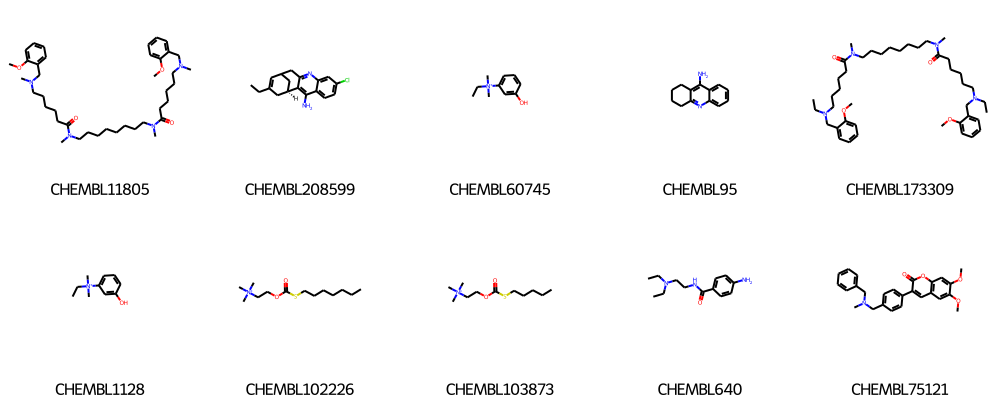

In [9]:
Draw.MolsToGridImage(list(df.ROMol[0:10]), legends = list(df.index[0:10]), molsPerRow=5)

In [10]:
#mols = [Chem.MolFromSmiles(smi) for smi in df.canonical_smiles ]

In [11]:
df["maccs"] = df.ROMol.apply(MACCSkeys.GenMACCSKeys)

,units,Ki,smiles,pKi,ROMol,maccs
molecule_chembl_id,,,,,,
CHEMBL11805,nM,0.104,COc1ccccc1CN(C)CCCCCC(=O)N(C)CCCCCCCCN(C)C(=O)...,9.982967,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."

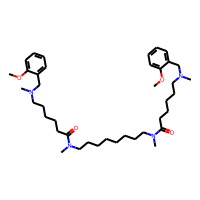

In [12]:
df.head(1)

In [13]:
#mols = [Chem.MolFromSmiles(smi) for smi in df.smiles ]
#fp = [AllChem.GetMorganFingerprintAsBitVect(m, 2) for m in mols]
MCCS = [MACCSkeys.GenMACCSKeys(mol).ToBitString() for mol in df['ROMol']]

In [14]:
key = MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles('C1(=C(SSC1=O)Cl)Cl'))
key.ToBitString()

'00000000000000000000000000000000000010000000000000000000000000000001000000000000010100011000000010000001000100000100000010001001000000100100000110000010001000000010110'

In [15]:
def smiles_to_fp(smiles, method="maccs", n_bits=2048):
    """
    Encode a molecule from a SMILES string into a fingerprint.

    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.

    """

    # convert smiles to RDKit mol object
    mol = Chem.MolFromSmiles(smiles)

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        return np.array(GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits))
    if method == "morgan3":
        return np.array(GetMorganFingerprintAsBitVect(mol, 3, nBits=n_bits))
    else:
        # NBVAL_CHECK_OUTPUT
        print(f"Warning: Wrong method specified: {method}. Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))

In [16]:
# Add column for fingerprint
#df["fp"] = df["smiles"].apply(smiles_to_fp)
#df.head(3)

**The fp_from_smiles** function is very slow and running it kill the kernel of the jupyter 

In [17]:
# def fp_from_smiles(smiles):
#     output = []
#     for f in fp :
#         arr = np.zeros((1,))
#         DataStructs.ConvertToNumpyArray(f, arr)
#         output.append(arr)
#     return np.asarray(output)
#     #return pd.DataFrame(data = output, index= df.index)

In [18]:
# df["canonical_smiles"]

In [19]:
# df["fingerprints_df"] = df["canonical_smiles"].apply(fp_from_smiles)

# # Look at head
# print("Shape of dataframe:", df.shape)
# df.head(3)
# # NBVAL_CHECK_OUTPUT

In [20]:
df.columns

Index(['units', 'Ki', 'smiles', 'pKi', 'ROMol', 'maccs'], dtype='object')

In [21]:
index = df.index

In [22]:
#df.to_csv('./databases/data_fp.csv', columns=['smiles','pKi','ROMol'])

In [23]:
#df = pd.read_csv('./databases/data_fp.csv', index_col=0)
#df.head(1)

Just a small check of the fingerprints

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 472 entries, CHEMBL11805 to CHEMBL193996
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   units   472 non-null    object 
 1   Ki      472 non-null    float64
 2   smiles  472 non-null    object 
 3   pKi     472 non-null    float64
 4   ROMol   472 non-null    object 
 5   maccs   472 non-null    object 
dtypes: float64(2), object(4)
memory usage: 25.8+ KB


In [25]:
length = len(MCCS[0])

In [26]:
MCCS_name = [f'MCCS_{i}' for i in range(length)]
MCCS_fp = [list(l) for l in MCCS]
df_MCCS = pd.DataFrame(MCCS_fp, index = df.index, columns=MCCS_name)
df_MCCS.head(1)

,MCCS_0,MCCS_1,MCCS_2,MCCS_3,MCCS_4,MCCS_5,MCCS_6,MCCS_7,MCCS_8,MCCS_9,...,MCCS_157,MCCS_158,MCCS_159,MCCS_160,MCCS_161,MCCS_162,MCCS_163,MCCS_164,MCCS_165,MCCS_166
molecule_chembl_id,,,,,,,,,,,,,,,,,,,,,
CHEMBL11805,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0


In [27]:
df_MCCS.shape

(472, 167)

In [28]:
#df['fp'].apply(pd.to_numeric, downcast='float')

In [29]:
print("The shape of the fingerprints dataset is ",df_MCCS.shape)
print("The shape of the original dataset is ",df.shape)

The shape of the fingerprints dataset is  (472, 167)
The shape of the original dataset is  (472, 6)


In [30]:
df_MCCS.isnull().sum().sum()

0

In [31]:
df_MCCS.dropna(how="any",inplace=True)

In [32]:
print("The shape of the new dataset is ",df_MCCS.shape)

The shape of the new dataset is  (472, 167)


In [33]:
data_columns = df.columns 
data_indices = df.index

In [34]:
#dfTest = (df.drop(columns= data_columns, axis=1).join(df[data_columns]).apply(pd.to_numeric, errors='coerce'))

In [35]:
#dfTest.head()

In [36]:
# Split the data into training and test set
x_train, x_test, y_train, y_test = train_test_split(
    df_MCCS, df[["pKi"]], test_size=0.3, random_state=42
)

# Print the shape of training and testing data
print("Shape of training data:", x_train.shape)
print("Shape of test data:", x_test.shape)
# NBVAL_CHECK_OUTPUT

Shape of training data: (330, 167)
Shape of test data: (142, 167)


In [83]:
# Neural network parameters
shape = (x_train.shape[1:])

In [64]:
x_train.shape[1:]

(167,)

In [110]:
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [111]:
def NN_model(shape):
    model = Sequential()
    model.add(Input(shape, name= 'InputLayer'))
    model.add(Dense(32, activation= 'relu', name = 'hiden1'))
    model.add(Dense(64, activation= 'relu', name = 'hiden2'))
    model.add(Dense(32, activation= 'relu', name = 'hiden3'))
    model.add(Dense(1, activation= 'linear', name= 'Output'))
    model.compile(optimizer = 'adam',
                 loss = mean_squared_error,
                 metrics = ['mae', 'mse', coeff_determination])
    return model

In [112]:
#df_MCCS.shape[0]

In [113]:
model = NN_model(shape)
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hiden1 (Dense)              (None, 32)                5376      
                                                                 
 hiden2 (Dense)              (None, 64)                2112      
                                                                 
 hiden3 (Dense)              (None, 32)                2080      
                                                                 
 Output (Dense)              (None, 1)                 33        
                                                                 
Total params: 9,601
Trainable params: 9,601
Non-trainable params: 0
_________________________________________________________________


In [114]:
#x_test

In [115]:
history = model.fit(x_train.astype(float),
                   y_train,
                batch_size=8,
                epochs=30,
                verbose=1, 
                validation_data=(x_test.astype(float), y_test)
                   )

Epoch 1/30
42/42 [==============================] - 0s 3ms/step - loss: 21.6329 - mae: 3.9489 - mse: 21.6329 - coeff_determination: -9.5089 - val_loss: 6.2998 - val_mae: 2.0362 - val_mse: 6.2998 - val_coeff_determination: -1.2312
Epoch 2/30
42/42 [==============================] - 0s 1ms/step - loss: 4.4015 - mae: 1.6433 - mse: 4.4015 - coeff_determination: -0.6967 - val_loss: 3.9402 - val_mae: 1.6050 - val_mse: 3.9402 - val_coeff_determination: -0.4328
Epoch 3/30
42/42 [==============================] - 0s 1ms/step - loss: 3.1350 - mae: 1.3892 - mse: 3.1350 - coeff_determination: -0.4491 - val_loss: 2.9662 - val_mae: 1.3753 - val_mse: 2.9662 - val_coeff_determination: -0.1018
Epoch 4/30
42/42 [==============================] - 0s 1ms/step - loss: 2.3921 - mae: 1.2227 - mse: 2.3921 - coeff_determination: -0.7260 - val_loss: 2.4473 - val_mae: 1.2185 - val_mse: 2.4473 - val_coeff_determination: 0.0753
Epoch 5/30
42/42 [==============================] - 0s 1ms/step - loss: 1.8202 - mae: 1

In [131]:
batch_sizes = [16, 32, 64, 128]
nb_epoch = 100

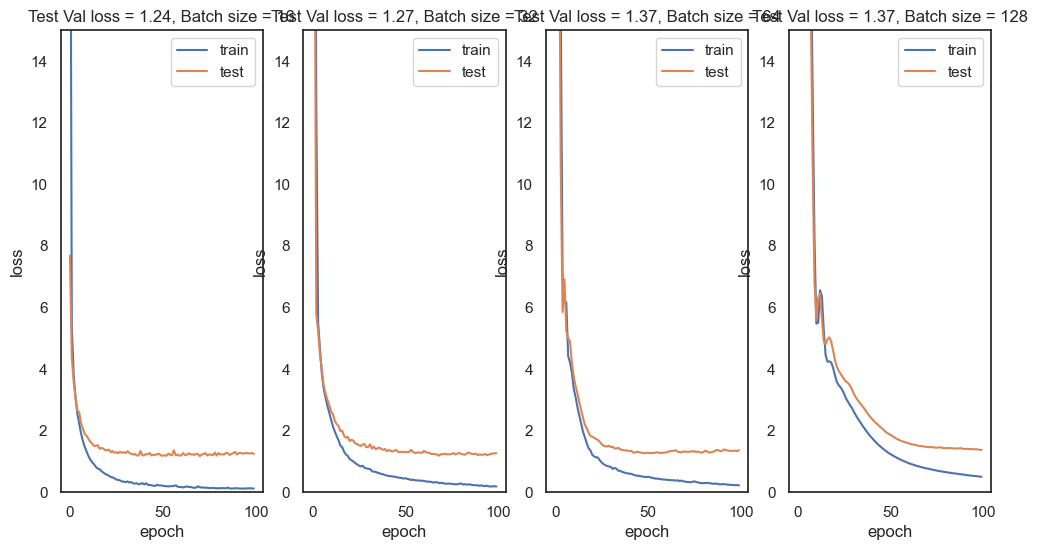

In [132]:
# Plot
fig = plt.figure(figsize=(12, 6))
sns.set_style('white')
for index, batch in enumerate(batch_sizes):
    fig.add_subplot(1, len(batch_sizes), index+1)
    model = NN_model(shape=shape)

    # Fit model on x_train, y_train data
    history = model.fit(
        x_train.astype(float),
        y_train,
        batch_size=batch,
        validation_data=(x_test.astype(float), y_test),
        verbose=0,
        epochs=nb_epoch,
    )
    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history["val_loss"], label="test")
    #plt.plot(history.history["coeff_determination"],label = "test")
    plt.legend(["train", "test"], loc="upper right")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.ylim((0, 15))
    plt.title(
        f"Test Val loss = {history.history['val_loss'][nb_epoch-1]:.2f}, " f"Batch size = {batch}"
    )
plt.show()

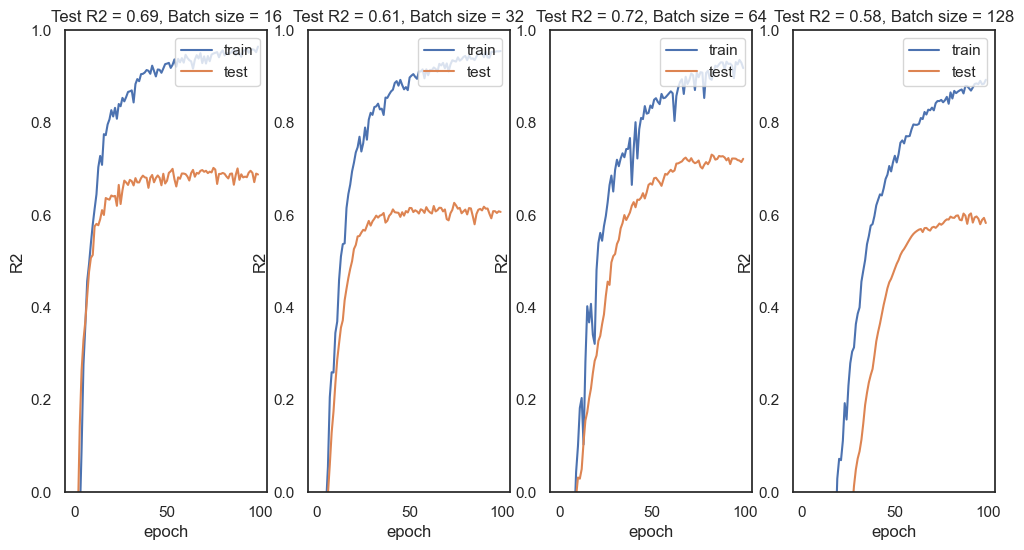

In [133]:
# Plot
fig = plt.figure(figsize=(12, 6))
sns.set_style('white')
for index, batch in enumerate(batch_sizes):
    fig.add_subplot(1, len(batch_sizes), index+1)
    model = NN_model(shape=shape)

    # Fit model on x_train, y_train data
    history = model.fit(
        x_train.astype(float),
        y_train,
        batch_size=batch,
        validation_data=(x_test.astype(float), y_test),
        verbose=0,
        epochs=nb_epoch,
    )
    plt.plot(history.history["coeff_determination"], label="train")
    plt.plot(history.history["val_coeff_determination"], label="test")
    #plt.plot(history.history["coeff_determination"],label = "test")
    plt.legend(["train", "test"], loc="upper right")
    plt.ylabel("R2")
    plt.xlabel("epoch")
    plt.ylim((0, 1))
    plt.title(
        f"Test R2 = {history.history['val_coeff_determination'][nb_epoch-1]:.2f}, " f"Batch size = {batch}"
    )
plt.show()